<center><img src=https://github.com/nccr-itmo/FEDOT/raw/master/docs/fedot_logo.png></img></center>

# <center>Решение задачи классификации при помощи фреймворка [FEDOT](https://github.com/nccr-itmo/FEDOT)</center>

## Введение

Для решения любой задачи при помощи методов машинного обучения, исследователю требуется пройти множество шагов: от предобработки данных, выбора наиболее качественных признаков, преобразования признаков, подбора модели и до настройка гиперпараметров для запуска.

Концепция задач **автоматического машинного обучения (AutoML)** направлена на уменьшении (или даже в полном исключении) участия человека в процессе решения задач машинного обучения. На основе доступных данных (обучающей выборки) осуществляется поиск оптимального **пайплайна** (последовательности действий над данными и моделей для предсказания) для наиболее лучшего решения задачи.

<center><img src=https://habrastorage.org/r/w1560/webt/5r/9t/sd/5r9tsdb-inbszzrmy_jnmpphiwe.png></img></center>

**FEDOT** - это фреймворк с открытым исходным кодом автоматического машинного обучения, который способен автоматизировать создание и оптимизацию пайплайнов машинного обучения и их элементов. 
Фреймворк позволяет компактно и эффективно решать различные задачи моделирования.

### Установка FEDOT

Наиболее простой способ установки фреймворка **FEDOT** через `pip`:

In [1]:
# !pip install fedot

Однако, на данный момент, мы рекомендуем вам его установить напрямую из master ветки репозитория:

In [2]:
!pip install --upgrade --force-reinstall --no-cache-dir --quiet --no-warn-script-location https://github.com/nccr-itmo/FEDOT/archive/master.zip

<div class="alert alert-block alert-info"><b>Примечание</b>: существуют альтернативные способы установки фреймворка и его зависимостей, с которыми можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/introduction/tutorial/quickstart.html">Quickstart</a></b> в нашей документации.</div>

### Данные

В качестве примера задачи классификации возьмем данные из OpenML [Kaggle Amazon Employee Access Challenge](https://www.openml.org/search?type=data&sort=runs&id=4135&status=active). Датасет состоит из реальный исторических данных, собранных за 2010 и 2011 годы. Сотрудникам вручную предоставлялся или запрещался доступ к ресурсам в заданный период времени. Данные использовались для создания алгоритма, способного помочь в предоставлении прав доступа для новых сотрудников.

Загрузим данные со страницы OpenML репозитория:

In [3]:
!wget -nc https://www.openml.org/data/download/1681098/phpmPOD5A.arff

File ‘phpmPOD5A.arff’ already there; not retrieving.



In [4]:
from scipy.io.arff import loadarff 
import pandas as pd

train_df = pd.DataFrame(loadarff('phpmPOD5A.arff')[0]).stack().str.decode('utf-8').unstack().astype('int64')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   RESOURCE          32769 non-null  int64
 1   MGR_ID            32769 non-null  int64
 2   ROLE_ROLLUP_1     32769 non-null  int64
 3   ROLE_ROLLUP_2     32769 non-null  int64
 4   ROLE_DEPTNAME     32769 non-null  int64
 5   ROLE_TITLE        32769 non-null  int64
 6   ROLE_FAMILY_DESC  32769 non-null  int64
 7   ROLE_FAMILY       32769 non-null  int64
 8   ROLE_CODE         32769 non-null  int64
 9   target            32769 non-null  int64
dtypes: int64(10)
memory usage: 2.8 MB


In [6]:
train_df.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,target
0,39353,85475,117961,118300,123472,117905,117906,290919,117908,1
1,17183,1540,117961,118343,123125,118536,118536,308574,118539,1
2,36724,14457,118219,118220,117884,117879,267952,19721,117880,1
3,36135,5396,117961,118343,119993,118321,240983,290919,118322,1
4,42680,5905,117929,117930,119569,119323,123932,19793,119325,1


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, random_state=42)

print(train.shape, test.shape)
print('')
print(train.target.value_counts())
print(test.target.value_counts())

(24576, 10) (8193, 10)

1    23148
0     1428
Name: target, dtype: int64
1    7724
0     469
Name: target, dtype: int64


Теперь мы готовы приступить к решению!

## Решение при помощи FEDOT

Для поиска оптимального решения этой задачи при помощи фреймоврка FEDOT необходимо всего лишь несколько строк. В первую очередь импортируем необходимые модули и классы.

In [8]:
from fedot.api.main import Fedot

auto_model = Fedot(
    problem='classification',
    timeout=60,
    cv_folds=10,
    metric='roc_auc',
    n_jobs=-1,
    preset='best_quality',
    logging_level=15, #без вывода warning-ов
    seed=42
)

В базовый класс api фреймворка `Fedot` мы передаем следующие параметры:
* `problem = 'classification'` - неообходимо дать понять какую задачу предстоить решать фреймворку
* `timeout = 60` - указать сколько у него есть времени в минутах для решения
* `cv_folds = 10` - количество фолдов для предовтращения переобучения
* `metric = 'roc_auc'` - какую метрику ему улучшать, в нашем случае метрику ROC-AUC
* `n_jobs = -1` - количество используемых ядер для выполнения распараллеливания процесса поиска оптимального пайплайна. -1 значит будем использовать все доступные
* `preset = 'best_quality'` -  используемый пресет моделей и операций. Для генерации будем использовать все доступные модели
* `seed = 42` - для фиксирования эксперимента укажем число случайного сида

<div class="alert alert-block alert-info"><b>Примечание</b>: существуют также и другие параметры для запуска FEDOT. Более подробнее можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/api/api.html">FEDOT API</a></b> в нашей документации.</div>

Далее можно приступить к запуску процесса поиска оптимального пайплайна и его обучения. Необходимо в метод `.fit()` передать данные для обучения. Можно указать путь до `.csv` файлов или передать переменные `pd.DataFrame` или `np.array`. 

In [9]:
pipeline = auto_model.fit(features=train, target='target')

2022-10-17 17:33:56,665 - AssumptionsHandler - Initial pipeline fitting started
2022-10-17 17:34:00,372 - AssumptionsHandler - Initial pipeline was fitted successfully
2022-10-17 17:34:00,374 - ApiComposer - Initial pipeline was fitted in 3.7 sec.
2022-10-17 17:34:00,379 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 60 min Set of candidate models: ['lgbm', 'logit', 'poly_features', 'isolation_forest_class', 'knn', 'bernb', 'rf', 'fast_ica', 'mlp', 'scaling', 'pca', 'normalization', 'dt', 'resample', 'qda']
2022-10-17 17:34:00,423 - ApiComposer - Pipeline composition started.
2022-10-17 17:34:00,428 - DataSourceSplitter - K-folds cross validation is applied.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-10-17 17:34:00,432 - MultiprocessingDispatcher - Number of used CPU's: 4
2022-10-17 17:34:43,619 - EvoGraphOptimizer - Generation num: 1
2022-10-17 17:34:43,621 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.ROCAUC'>>: -0.8351, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.19999999999999998}]
2022-10-17 17:34:43,622 - EvoGraphOptimizer - no improvements for 0 iterations
2022-10-17 17:34:43,623 - EvoGraphOptimizer - spent time: 0.7 min
2022-10-17 17:34:44,454 - MultiprocessingDispatcher - Number of used CPU's: 4
2022-10-17 17:40:25,509 - EvoGraphOptimizer - Generation num: 2
2022-10-17 17:40:25,512 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.ROCAUC'>>: -0.8446999999999999, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.19999999999999998}]
2022-10-17 17:40:25,513 - EvoGraphO

Generations:   0%|          | 1/10000 [41:39<?, ?gen/s]

2022-10-17 18:15:39,609 - OptimisationTimer - Composition time: 41.653 min
2022-10-17 18:15:39,610 - OptimisationTimer - Algorithm was terminated due to processing time limit
2022-10-17 18:15:39,615 - GPComposer - GP composition finished
2022-10-17 18:15:39,617 - DataSourceSplitter - K-folds cross validation is applied.
2022-10-17 18:15:39,620 - ApiComposer - Hyperparameters tuning started with 18 min. timeout
2022-10-17 18:15:39,621 - PipelineTuner - Hyperparameters optimization start


  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2022-10-17 18:16:43,937 - build_posterior_wrapper took 0.003418 seconds
2022-10-17 18:16:43,938 - TPE using 0 trials
  0%|          | 1/100000 [00:18<521:59:32, 18.79s/trial, best loss: -0.8351000000000001]2022-10-17 18:17:02,728 - build_posterior_wrapper took 0.002010 seconds
2022-10-17 18:17:02,730 - TPE using 1/1 trials with best loss -0.835100
  0%|          | 2/100000 [00:57<845:31:47, 30.44s/trial, best loss: -0.8448]            2022-10-17 18:17:41,321 - build_posterior_wrapper took 0.001997 seconds
2022-10-17 18:17:41,323 - TPE using 2/2 trials with best loss -0.844800
  0%|          | 3/100000 [02:39<1759:31:38, 63.34s/trial, best loss: -0.8448]2022-10-17 18:19:23,824 - build_posterior_wrapper took 0.002002 seconds
2022-10-17 18:19:23,826 - TPE using 3/3 trials with best loss -0.844800
  0%|          | 4/100000 [03:56<1903:42:35, 68.54s/trial, best loss: -0.8448]2022-10-17 18:20:40,319 - build_posterior_wrapper took 0.00

После окончания выполнения кода, можно взглянуть на структуру найденного оптимального пайплайна.

_Первый вариант в текстовой форме:_

In [10]:
pipeline.print_structure()

Pipeline structure:
{'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': -1, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.7313701555074177, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
scaling - {}


_Второй вариант отрисовать граф:_

2022-10-17 18:37:29,392 - OperationTypesRepository - Operation scaling not found in the repository


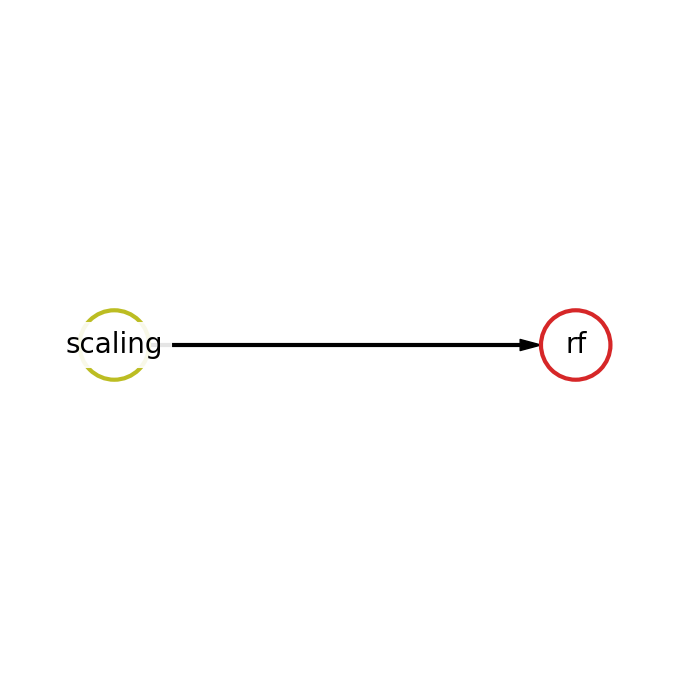

In [11]:
pipeline.show(node_size_scale=0.5, dpi=100)

Теперь сделаем предсказания для тестовых данных и посмотрим на полученный результат по метрикам

In [12]:
prediction = auto_model.predict(features=test)

auto_model.get_metrics()

{'roc_auc': 0.847, 'f1': 0.9491028927132918}

Также можно отрисовать на графике

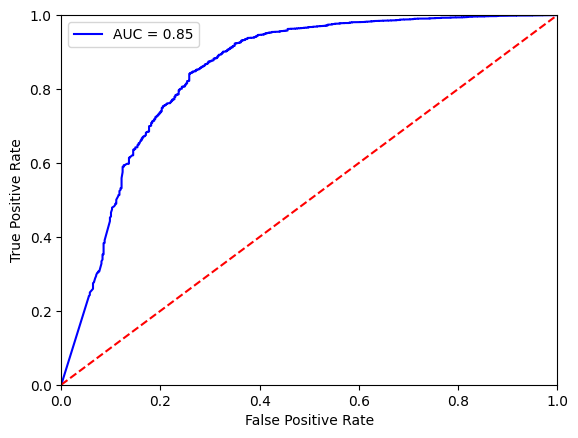

In [13]:
auto_model.plot_prediction()

## Baseline

Давайте попробуем запустить обучение на какой-нибудь конкретной модели и сравним его с решением полученного из фреймворка FEDOT. 

In [14]:
train, test = train_test_split(train_df, random_state=42)

In [15]:
baseline_model = Fedot(
    problem='classification',
    timeout=1,
    metric='roc_auc',
    seed=42
)

Для запуска процесса генерации пайлпайнов состоящих из одной модели достаточно в Fedot указать в параметре `predefined_model` модель (или даже набор моделей). В нашем случае укажем `dt` (decision tree) и также передадим данные для обучения и укажем название целевого признака

In [16]:
baseline_model.fit(
    features=train,
    target='target',
    predefined_model='dt'
)

2022-10-17 18:40:15,578 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [dt]}


{'depth': 1, 'length': 1, 'nodes': [dt]}

In [17]:
prediction = baseline_model.predict_proba(features=test)

baseline_model.get_metrics()

{'roc_auc': 0.686, 'f1': 0.9262785304528256}

In [18]:
print('Metirc\t\tROC-AUC')
print('Baseline:\t', baseline_model.get_metrics()['roc_auc'])
print('AutoML FEDOT:\t', auto_model.get_metrics()['roc_auc'])

Metirc		ROC-AUC
Baseline:	 0.686
AutoML FEDOT:	 0.847


## Анализ и сохранение истории генерации пайплайнов 

Для сохранения истории процесса генераци в формате JSON воспользуемся следующей командой

In [19]:
auto_model.history.save();

In [24]:
auto_model.history.save("classification_history.json");

Из истории можно посмотреть на изменение значения метрик для каждого этапа генерации

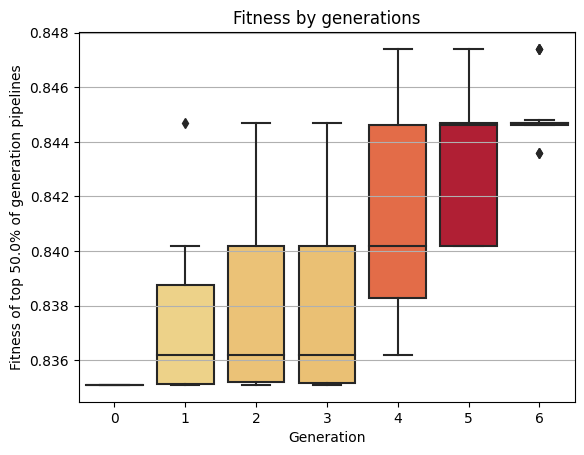

In [20]:
auto_model.history.show.fitness_box(best_fraction=0.5, dpi=100)

Или можно посмотреть насколько преобладают конкретные методы в генерации

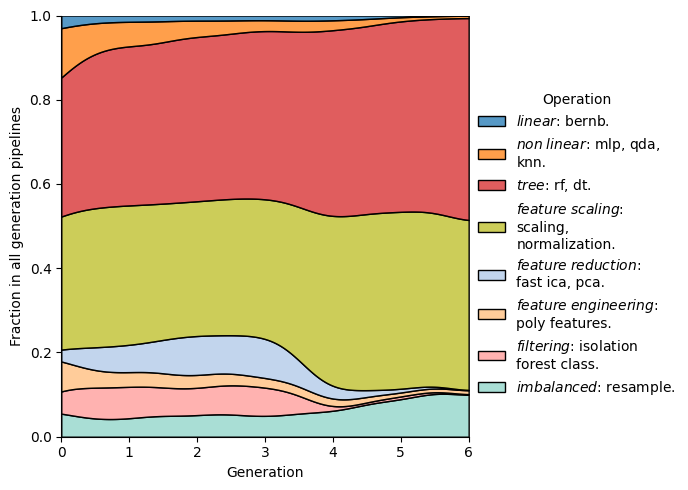

In [21]:
auto_model.history.show.operations_kde(dpi=100)

Также можно взглянуть на это в динамике

In [22]:
from IPython.display import HTML

auto_model.history.show.operations_animated_bar(save_path='classification_plots/history_animated_bars.gif', show_fitness=True, dpi=100)
HTML('<img src="classification_plots/history_animated_bars.gif">')

## Послесловие

В данном блокноте мы показали вам как запустить фреймворк **FEDOT** для решения задачи классификации при помощи API. Как можно было заметить, для этого потребовалось совсем немного строк кода.

Теперь и вы можете попробовать запустить фреймворк автоматического машинного обучения **FEDOT** на своих данных.

<i class="fa fa-github" style="font-size:24px"></i> - <a href="https://github.com/nccr-itmo/FEDOT"> Наш репозиторий </a>

<i class="fa fa-telegram" style="font-size:24px;color:blue"></i> - <a href="https://t.me/FEDOT_helpdesk">Telegram канал поддержки</a>

<i class="fa fa-youtube-play" style="font-size:24px;color:red"></i> - <a href="https://www.youtube.com/channel/UC4K9QWaEUpT_p3R4FeDp5jA">Наш канал на Youtube</a>